# Module 5: The Challenge of Sampling

Welcome to Module 5! In Module 4, we successfully simulated simple 1D systems using both NVE (Velocity Verlet) and NVT (Langevin) dynamics. We saw how a particle behaves in a simple harmonic potential and, more importantly, in a double-well potential.

The double-well simulation highlighted a critical challenge in Molecular Dynamics: the **sampling problem**. This module delves into why sampling can be difficult, introduces the concept of Collective Variables to describe complex processes, and lays the groundwork for understanding Free Energy, which is often the target quantity we want to calculate.

## Setup: Imports and Potential Functions

Let's import the necessary libraries again and redefine our potential and force functions, plus the Langevin integrator from Module 4.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings # To handle potential log(0) issues

# Plotting style configuration (optional)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (6,4) # Default figure size
plt.rcParams['lines.linewidth'] = 2

# Assume Boltzmann constant k_B = 1 for simplicity in reduced units
k_B = 1.0

# --- Potential/Force Functions (from Module 4) ---
def potential_sh(x, k):
  """Calculates the potential energy of a simple harmonic oscillator."""
  return 0.5 * k * x**2

def force_sh(x, k):
  """Calculates the force on a particle in a simple harmonic potential."""
  return -k * x

def potential_dw(x, a, b):
  """Calculates the potential energy of a double-well potential."""
  return a * x**4 - b * x**2

def force_dw(x, a, b):
  """Calculates the force from a double-well potential."""
  return -4 * a * x**3 + 2 * b * x

# --- Langevin Integrator (from Module 4) ---
def Velocity_verlet_langevin(x_curr, v_curr, mass, dt, gamma, target_temp, force_func, **force_args):
    """
    Performs one step of Langevin dynamics using the BAOAB integrator.

    Args:
        x_curr (float): Current position.
        v_curr (float): Current velocity.
        mass (float): Mass of the particle.
        dt (float): Time step.
        gamma (float): Friction coefficient.
        target_temp (float): Target temperature (kB=1).
        force_func (callable): Function to calculate the physical force.
        **force_args: Additional keyword arguments for the force function.

    Returns:
        tuple: (x_new, v_new) - Updated position and velocity.
    """

    # Update velocity by half step with current force
    f_curr = force_func(x_curr, **force_args)
    v_half_b = v_curr + (f_curr / mass) * (dt / 2.0)

    # Update position by half step
    x_half_a = x_curr + v_half_b * (dt / 2.0)

    # Apply friction and random kick
    c1 = np.exp(-gamma * dt)
    # Ensure target_temp is non-negative before sqrt
    c2 = np.sqrt(k_B * max(0, target_temp) * (1.0 - c1**2) / mass)
    # Generate random number from standard normal distribution
    random_kick = np.random.normal(0, 1)
    v_half_o = c1 * v_half_b + c2 * random_kick

    # Update position by second half step
    x_new = x_half_a + v_half_o * (dt / 2.0)

    # Update velocity by half step with force at *new* position
    f_new = force_func(x_new, **force_args)
    v_new = v_half_o + (f_new / mass) * (dt / 2.0)

    return x_new, v_new


# --- Parameters from Module 4 ---
# SHO
k_sh = 1.0
# Double Well
a_dw = 1.0
b_dw = 4.0
minima_pos = np.sqrt(b_dw / (2 * a_dw))
print(f"Minimum Position for DW: {minima_pos:.2f}")
minima_val = potential_dw(minima_pos, a=a_dw, b=b_dw)
barrier_top_val = potential_dw(0, a=a_dw, b=b_dw)
barrier_height = barrier_top_val - minima_val

print("Setup complete. Functions and parameters loaded.")
print(f"Double-well barrier height: {barrier_height:.2f}")

Minimum Position for DW: 1.41
Setup complete. Functions and parameters loaded.
Double-well barrier height: 4.00


## Lesson 1: Timescales and Rare Events

Recall our NVE simulation of the particle in the double-well potential (from the 1D simulation module). Depending on the initial energy we gave the particle:
* **If the total energy was less than the barrier height:** The particle remained trapped in its initial well for the entire simulation. It couldn't sample the other stable state.
* **If the total energy was just slightly above the barrier height:** The particle might have crossed the barrier, but perhaps only a few times during the simulation run.
* **If the total energy was much higher than the barrier:** The particle crossed back and forth frequently.

This illustrates a fundamental limitation of standard MD simulations. Many interesting biological or chemical processes involve transitions between **metastable states** separated by significant **energy barriers**. Examples include:
* Protein folding/unfolding
* Ligand binding/unbinding
* Conformational changes in molecules
* Chemical reactions
* Phase transitions

These transitions might occur on timescales of microseconds ($\mu$s), milliseconds (ms), or even longer in reality. However, due to the tiny time step required ($\sim$femtoseconds, fs), even a very long MD simulation (millions or billions of steps) might only cover nanoseconds (ns) or microseconds ($\mu$s) of real time.

If the timescale of the process we're interested in is much longer than the simulation time achievable, the transition event becomes a **"rare event"** in the context of our simulation. We simply won't observe enough transitions (or maybe any at all) to get meaningful statistics or understand the process kinetics or thermodynamics.

**The Sampling Problem:** Standard MD tends to get trapped in local energy minima (like the wells in our double-well potential) and fails to adequately explore the entire relevant configuration space, especially regions separated by high energy barriers, within feasible simulation times.

## Lesson 2: Collective Variables (CVs)

To study complex processes like barrier crossing, folding, or binding, it's often helpful to describe the progress of the process using one or a few key parameters, rather than tracking the coordinates of all atoms ($3N$ coordinates!). These key parameters are called **Collective Variables (CVs)**, **order parameters**, or **reaction coordinates**.

A good CV should:
* Distinguish between the initial state, final state, and any intermediate/transition states.
* Capture the essential motion or change occurring during the process.

**Examples of CVs:**
* **Distance:** Between two specific atoms or centers of mass of molecular groups (e.g., distance between a drug and its binding site).
* **Angle:** Formed by three atoms (e.g., bending angle in a molecule).
* **Dihedral Angle:** Rotation around a bond (e.g., backbone $\phi/\psi$ angles in proteins, crucial for conformation).
* **Radius of Gyration:** A measure of the overall compactness of a molecule (e.g., for protein folding).
* **Coordination Number:** The number of neighboring atoms/molecules within a certain distance (e.g., number of water molecules around an ion).

**CVs in our 1D System:**
For our simple 1D double-well system, the choice of CV is straightforward: the **position $x$ itself** is the natural collective variable. It clearly distinguishes the left well ($x \approx -\sqrt{b/2a}$), the right well ($x \approx +\sqrt{b/2a}$), and the transition region near the barrier top ($x \approx 0$).

The goal of many simulation studies, especially those involving enhanced sampling, is to understand how the system behaves as a function of one or more chosen CVs. We often want to calculate the *free energy* profile along a CV.

## Lesson 3: Introduction to Free Energy

Why are we interested in calculating properties along a CV? Often, the goal is to determine the **Free Energy** profile along that coordinate.

**Conceptual Overview:**
You might recall Gibbs Free Energy ($G$) or Helmholtz Free Energy ($A$ or $F$) from thermodynamics. Free energy represents the amount of energy available to do useful work and determines the spontaneity of processes at constant temperature and pressure (Gibbs) or constant temperature and volume (Helmholtz). Systems tend to evolve towards states of lower free energy.

* **Low free energy regions** correspond to **stable or metastable states** (like the bottoms of the wells in our double-well potential). These states have high probability of being occupied.
* **High free energy regions** correspond to **unstable states or transition barriers**. These states have low probability of being occupied.

**Free Energy and Probability:**
Statistical mechanics provides a fundamental link between the free energy $F$ of a system as a function of a collective variable $q$ and the probability $P(q)$ of observing the system with that value of the CV:

$$ F(q) = -k_B T \ln P(q) + C $$

where:
* $k_B$ is the Boltzmann constant.
* $T$ is the absolute temperature.
* $P(q)$ is the probability density of finding the system at a specific value $q$ of the collective variable.
* $C$ is an arbitrary constant (since absolute free energy is often not needed, only differences).

This equation is crucial! It tells us that if we could somehow determine the probability distribution $P(q)$ along our chosen CV, we could directly calculate the free energy profile $F(q)$.

**Potential of Mean Force (PMF):**
The free energy profile along a collective variable, $F(q)$, is often called the **Potential of Mean Force (PMF)**. It represents the effective potential energy experienced by the system as it moves along the coordinate $q$, averaged over all other degrees of freedom. The negative gradient of the PMF gives the average force acting along the CV.

**Calculating PMF from Simulation Data:**
If we run a long enough simulation in the NVT ensemble (where temperature T is constant), we can approximate $P(q)$ by creating a histogram of the observed values of our CV $q$.
1. Run an NVT simulation (e.g., using Langevin dynamics).
2. Record the values of the CV (in our 1D case, the position $x$) at regular intervals.
3. Create a histogram of these recorded CV values.
4. Normalize the histogram counts to get an estimate of the probability density $P(q)$.
5. Calculate the PMF using $F(q) = -k_B T \ln P(q)$.

Let's try this for our 1D systems.

### Example 1: PMF for the Simple Harmonic Oscillator

First, let's run an NVT simulation for the SHO using the Langevin integrator from Module 4. We need a reasonably long simulation to get good statistics for the histogram.

In [ ]:
# NVT Langevin Simulation Parameters for SHO PMF
mass = 1.0
dt = 0.01
gamma = 1.0          # Friction coefficient
target_temp_sho = 1.0  # Target temperature (kB=1)
n_steps_sho_pmf = 100000 # Longer simulation for better sampling
record_stride = 10     # Record position every 'record_stride' steps

# Arrays to store NVT results (only need positions for PMF)
n_recorded_steps = n_steps_sho_pmf // record_stride
positions_nvt_sho = np.zeros(n_recorded_steps)

# Initial conditions
x_curr = 0.0 # Start at bottom
v_curr = np.sqrt(target_temp_sho * k_B / mass) # Start with typical velocity

# --- NVT Langevin Simulation Loop (SHO) ---
print(f"Starting NVT (Langevin) SHO simulation for PMF ({n_steps_sho_pmf} steps)...")
record_index = 0
for i in range(n_steps_sho_pmf):
    x_curr, v_curr = Velocity_verlet_langevin(
        x_curr, v_curr, mass, dt, gamma, target_temp_sho,
        force_sh, k=k_sh
    )
    # Record position at specified stride
    if i % record_stride == 0:
        if record_index < n_recorded_steps:
            positions_nvt_sho[record_index] = x_curr
            record_index += 1

print(f"NVT (Langevin) SHO Simulation finished. Recorded {record_index} positions.")

Starting NVT (Langevin) SHO simulation for PMF (100000 steps)...
NVT (Langevin) SHO Simulation finished. Recorded 10000 positions.


Now, let's calculate the histogram of the recorded positions and compute the PMF.

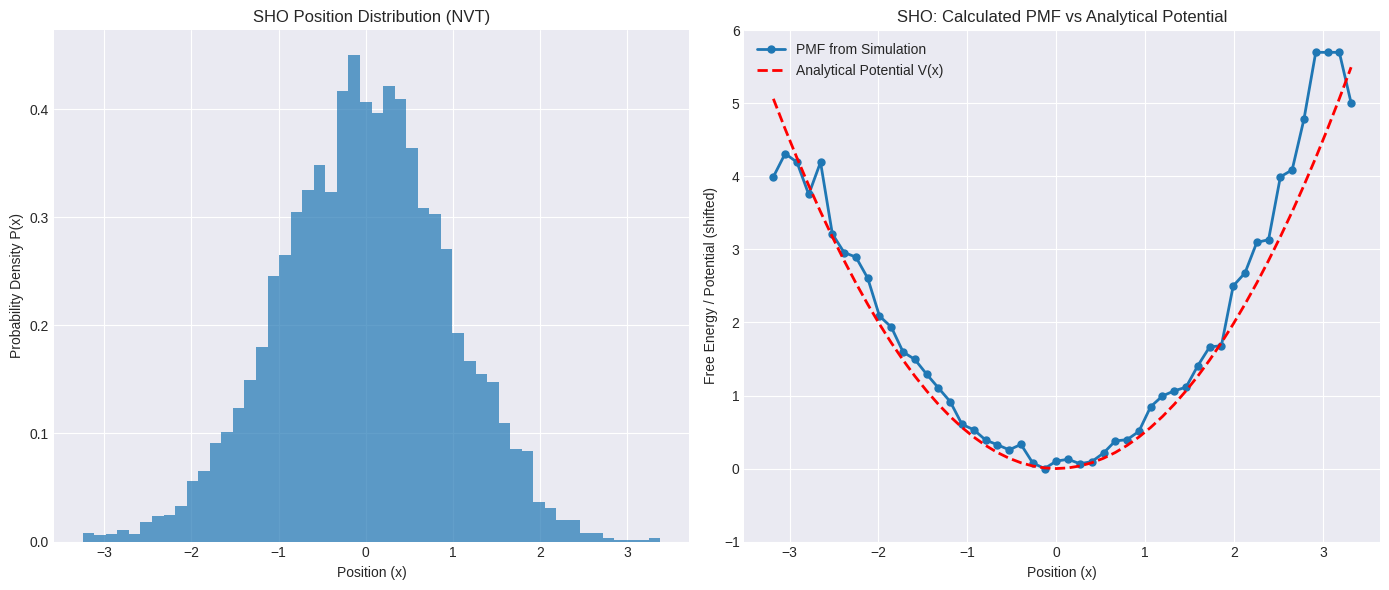

SHO PMF calculation and plotting complete.


In [ ]:
# Calculate Histogram
n_bins = 50 # Number of bins for the histogram
hist_sho, bin_edges_sho = np.histogram(positions_nvt_sho, bins=n_bins, density=True)
# 'density=True' normalizes histogram so the area integrates to 1 (approximates PDF)

# Get bin centers
bin_centers_sho = 0.5 * (bin_edges_sho[1:] + bin_edges_sho[:-1])

# Calculate PMF: F(x) = -kB * T * ln(P(x))
# Avoid log(0) for empty bins by adding a small epsilon or filtering
pmf_sho = np.full_like(hist_sho, np.inf) # Initialize with infinity
non_zero_mask = hist_sho > 1e-9 # Mask for bins with non-negligible probability
with warnings.catch_warnings(): # Suppress log(0) warnings safely
    warnings.simplefilter("ignore", category=RuntimeWarning)
    pmf_sho[non_zero_mask] = -k_B * target_temp_sho * np.log(hist_sho[non_zero_mask])

# Shift PMF so its minimum is at zero for easier comparison
pmf_sho -= np.min(pmf_sho[np.isfinite(pmf_sho)]) # Subtract minimum finite value

# Calculate analytical potential for comparison
analytical_potential_sho = potential_sh(bin_centers_sho, k=k_sh)
analytical_potential_sho -= np.min(analytical_potential_sho) # Shift minimum to zero

# --- Plot Histogram and PMF (SHO) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Histogram
axes[0].hist(positions_nvt_sho, bins=n_bins, density=True, label='Position Histogram', alpha=0.7)
axes[0].set_xlabel("Position (x)")
axes[0].set_ylabel("Probability Density P(x)")
axes[0].set_title("SHO Position Distribution (NVT)")
axes[0].grid(True)

# Plot PMF vs Analytical Potential
axes[1].plot(bin_centers_sho, pmf_sho, 'o-', label="PMF from Simulation", markersize=5)
axes[1].plot(bin_centers_sho, analytical_potential_sho, '--', label="Analytical Potential V(x)", color='red')
axes[1].set_xlabel("Position (x)")
axes[1].set_ylabel("Free Energy / Potential (shifted)")
axes[1].set_title("SHO: Calculated PMF vs Analytical Potential")
axes[1].set_ylim(-1, barrier_height * 1.5 if barrier_height > 0 else 5) # Adjust ylim based on expected energy range
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("SHO PMF calculation and plotting complete.")

For the Simple Harmonic Oscillator, if the simulation is long enough, the calculated PMF should match the analytical potential energy curve $V(x) = \frac{1}{2}kx^2$ very well (after shifting the minimum to zero). This confirms that the simulation correctly samples the Boltzmann distribution $P(x) \propto e^{-V(x)/k_B T}$ for this simple potential.

### Example 2: PMF for the Double-Well Potential

Now, let's repeat the process for the double-well potential. Here, we expect to see the sampling problem more clearly, especially if the temperature is not significantly higher than the barrier height. We'll use a temperature comparable to the barrier height.

In [ ]:
# NVT Langevin Simulation Parameters for DW PMF
mass = 1.0
dt = 0.01
gamma = 1.0          # Friction coefficient
# Choose temperature carefully: Try T ~ barrier height first
target_temp_dw = barrier_height * 0.1 # e.g., 10% of barrier height (kB=1)
n_steps_dw_pmf = 200000 # Longer simulation needed for DW
record_stride = 10     # Record position every 'record_stride' steps

print(f"Target Temperature for DW: {target_temp_dw:.2f} (Barrier Height: {barrier_height:.2f})")

# Arrays to store NVT results
n_recorded_steps_dw = n_steps_dw_pmf // record_stride
positions_nvt_dw = np.zeros(n_recorded_steps_dw)

# Initial conditions (start in one well)
x_curr = -minima_pos # Start at the left minimum
v_curr = 0.0         # Start at rest

# --- NVT Langevin Simulation Loop (DW) ---
print(f"Starting NVT (Langevin) DW simulation for PMF ({n_steps_dw_pmf} steps)...")
record_index = 0
for i in range(n_steps_dw_pmf):
    x_curr, v_curr = Velocity_verlet_langevin(
        x_curr, v_curr, mass, dt, gamma, target_temp_dw,
        force_dw, a=a_dw, b=b_dw
    )
    # Record position at specified stride
    if i % record_stride == 0:
        if record_index < n_recorded_steps_dw:
            positions_nvt_dw[record_index] = x_curr
            record_index += 1

print(f"NVT (Langevin) DW Simulation finished. Recorded {record_index} positions.")

Target Temperature for DW: 0.40 (Barrier Height: 4.00)
Starting NVT (Langevin) DW simulation for PMF (200000 steps)...
NVT (Langevin) DW Simulation finished. Recorded 20000 positions.


Calculate the histogram and PMF for the double-well simulation. Pay attention to the barrier region ($x \approx 0$).

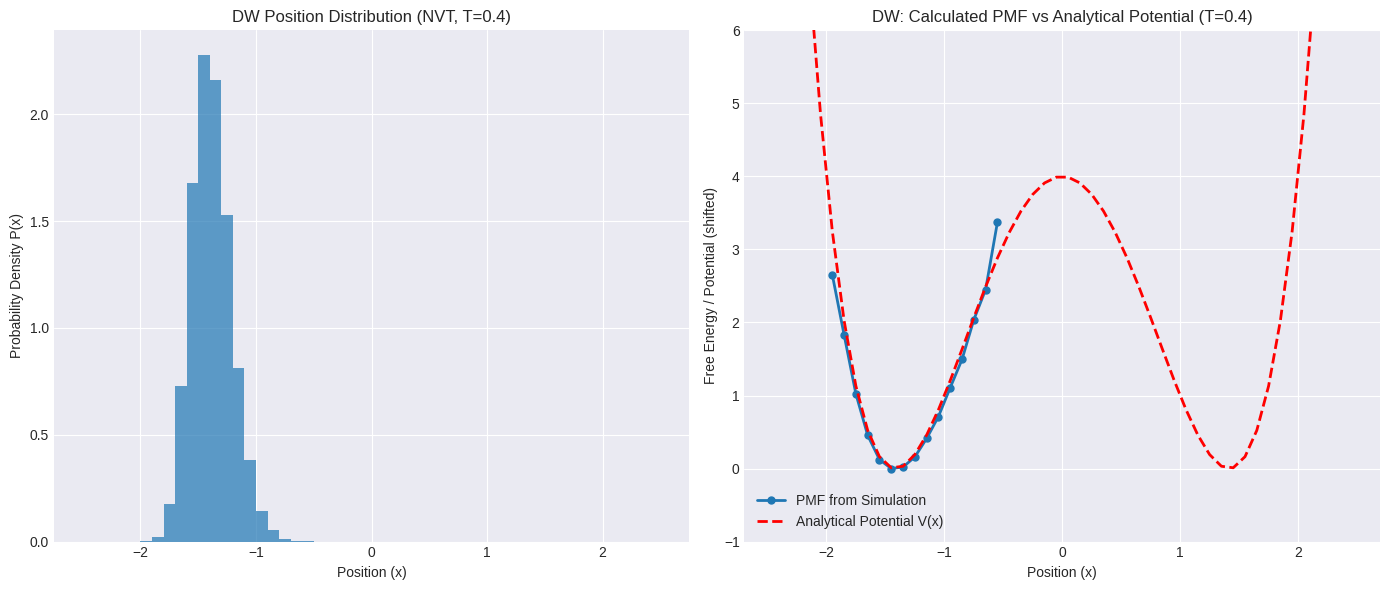

DW PMF calculation and plotting complete.


In [ ]:
# Calculate Histogram
n_bins = 50 # Number of bins for the histogram
hist_dw, bin_edges_dw = np.histogram(positions_nvt_dw, bins=n_bins, range=(-2.5, 2.5), density=True) # Ensure range covers both wells

# Get bin centers
bin_centers_dw = 0.5 * (bin_edges_dw[1:] + bin_edges_dw[:-1])

# Calculate PMF: F(x) = -kB * T * ln(P(x))
pmf_dw = np.full_like(hist_dw, np.inf) # Initialize with infinity
non_zero_mask_dw = hist_dw > 1e-9 # Mask for bins with non-negligible probability
with warnings.catch_warnings(): # Suppress log(0) warnings safely
    warnings.simplefilter("ignore", category=RuntimeWarning)
    pmf_dw[non_zero_mask_dw] = -k_B * target_temp_dw * np.log(hist_dw[non_zero_mask_dw])

# Shift PMF so its minimum is at zero
min_pmf_val = np.min(pmf_dw[np.isfinite(pmf_dw)])
if np.isfinite(min_pmf_val):
    pmf_dw -= min_pmf_val
else:
    print("Warning: Could not find finite minimum PMF value. PMF might be empty.")


# Calculate analytical potential for comparison
analytical_potential_dw = potential_dw(bin_centers_dw, a=a_dw, b=b_dw)
analytical_potential_dw -= minima_val # Shift minimum to zero

# --- Plot Histogram and PMF (DW) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Histogram
axes[0].hist(positions_nvt_dw, bins=n_bins, range=(-2.5, 2.5), density=True, label='Position Histogram', alpha=0.7)
axes[0].set_xlabel("Position (x)")
axes[0].set_ylabel("Probability Density P(x)")
axes[0].set_title(f"DW Position Distribution (NVT, T={target_temp_dw:.1f})")
axes[0].grid(True)

# Plot PMF vs Analytical Potential
axes[1].plot(bin_centers_dw, pmf_dw, 'o-', label="PMF from Simulation", markersize=5)
axes[1].plot(bin_centers_dw, analytical_potential_dw, '--', label="Analytical Potential V(x)", color='red')
axes[1].set_xlabel("Position (x)")
axes[1].set_ylabel("Free Energy / Potential (shifted)")
axes[1].set_title(f"DW: Calculated PMF vs Analytical Potential (T={target_temp_dw:.1f})")
axes[1].set_ylim(-1, barrier_height * 1.5 if barrier_height > 0 else 5) # Adjust ylim
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("DW PMF calculation and plotting complete.")

### Discussion: The Sampling Problem in the Double Well

Look closely at the histogram and the calculated PMF for the double-well potential.
* **Histogram:** Did the simulation spend significant time near the barrier top ($x \approx 0$)? Or did it mostly stay within one or both wells? The probability density $P(x)$ will be very low in regions the simulation didn't visit often.
* **PMF:** Because $F(x) \propto -\ln P(x)$, regions with very low probability $P(x)$ will correspond to very high (or infinite, if $P(x)=0$) free energy in our calculated PMF.
    * You might see large gaps or infinite values in the PMF around the barrier region.
    * If the temperature was too low or the simulation too short, the PMF might only show one of the wells, completely missing the other side of the potential.

**This is the sampling problem in action!** The standard NVT simulation, even with the correct Langevin thermostat, struggles to gather enough statistics in the high-energy barrier region. The calculated PMF is therefore unreliable or incomplete in these crucial areas.

**Why we need Enhanced Sampling:** To get an accurate PMF across the entire range, including the transition barrier, we need methods that *force* the simulation to spend more time in these high-energy regions than it normally would. This is precisely what techniques like Umbrella Sampling (Module 6) and Metadynamics (Module 7) are designed to do. They introduce biases that counteract the energy barriers, allowing for better sampling and a more complete reconstruction of the free energy landscape.

---
End of Module 5. We've explored the theoretical challenges behind MD simulations and seen a practical demonstration:

* **Timescales and Rare Events:** Standard MD struggles to simulate processes that are slow due to high energy barriers.
* **Collective Variables (CVs):** We can simplify complex processes by describing them with one or a few key parameters (like position 'x' in our 1D case).
* **Free Energy (PMF):** This thermodynamic quantity is linked to the probability of observing a state ($F(q) \propto -\ln P(q)$) and is often the target of our calculations.
* **Sampling Problem Demonstration:** By calculating the PMF from standard NVT simulations, we observed that while it works well for simple potentials (SHO), it fails to capture the full landscape for potentials with significant barriers (Double Well), highlighting the poor sampling of high-energy regions.

With this understanding and practical illustration of the sampling problem, we are now ready to learn techniques designed to tackle it. In Module 6, we will implement our first enhanced sampling method: **Umbrella Sampling**.